# SOSE HEAT BUDGET

Difference btwn implicit and explicit diffusivity terms? Does one rep isopycnal and other rep diapycnal mixing?
How do we isolate iso/diapycnal mixing term from the other term?

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.60.120:38067")
client

Client Scheduler: tcp://10.32.60.120:38067 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 46.00 GB


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [ ]:
#example
cat_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml'
cat = intake.Catalog(cat_url)
ds = cat.atmosphere.gmet_v1.to_dask()

In [4]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

##### Another way to load (but slower)
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-data/SOSE'))

ds

In [ ]:
ocean_cat.walk(depth=5)

In [5]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

In [ ]:
import xgcm
grid = xgcm.Grid(ds, periodic=('XC', 'YC'))
grid

# Heat budget for Weddell Gyre

In [ ]:
#why does 'isel' take so long to compute with

In [5]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time').load()

In [6]:
surface_mask = (coords.hFacC[0]>0).load()

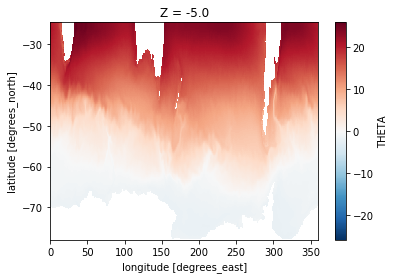

In [7]:
sst_mean.where(surface_mask).plot()

In [8]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat =-80

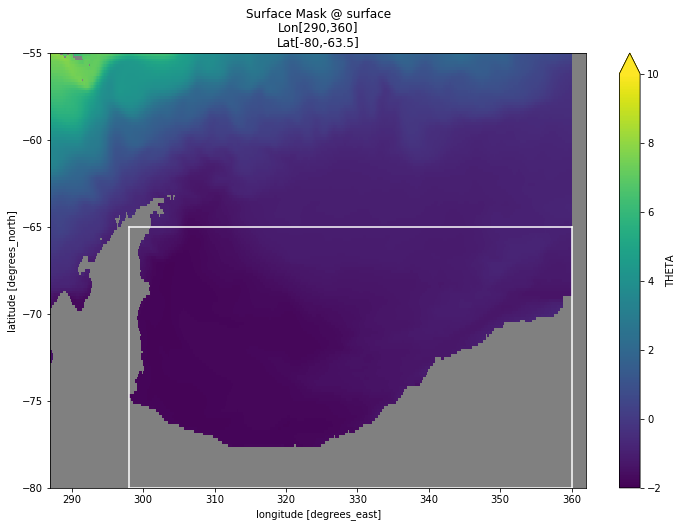

In [11]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ surface\nLon[290,360]\nLat[-80,-63.5]');

In [12]:
sst_mean.YC.isel(YC=74)

<xarray.DataArray 'YC' ()>
array(-65.54163, dtype=float32)
Coordinates:
    YC       float32 -65.54163
    Z        float32 -5.0
Attributes:
    axis:           Y
    coordinate:     YC XC
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [13]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [ ]:
dsr.ADVy_TH.sel(YG=upper_lat, method='nearest')

In [14]:
#advective flux
adv_flux_y = dsr.ADVy_TH.sel(**lon_range).sel(YG=upper_lat, method='nearest').sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_TH.sel(**lat_range).sel(XG=right_lon, method='nearest').sum(dim=['YC', 'Z']).load()
adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-13221805., -13907859., -16001169., ..., -13338161.,  -9747787.,
       -11887119.], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [ ]:
yg_index = dsr.indexes['YG']
yg_index.get_loc(-60, method='nearest')

In [ ]:
adv_flux_y

In [15]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.sel(**lon_range).sel(YG=upper_lat, method='nearest').sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_TH.sel(**lat_range).sel(XG=360, method='nearest').sum(dim=['YC', 'Z']).load()
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ -7607.662, -13723.151,  -6192.76 , ...,  37631.457,  43410.203,
        30665.426], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [16]:
#vertical flux
t_flux_z = (dsr.TFLUX.sel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([5.490894e+13, 6.297803e+13, 8.621291e+13, ..., 4.101646e+13,
       5.219860e+13, 8.672655e+13], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [17]:
coords.rA.sel(YC=-63.5, method='nearest')

<xarray.DataArray 'rA' (XC: 2160)>
dask.array<shape=(2160,), dtype=float32, chunksize=(2160,)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [18]:
dsr.WTHMASS.sel(YC=-63.4583, method='nearest')

<xarray.DataArray 'WTHMASS' (time: 438, Zl: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    standard_name:  WTHMASS
    units:          degC.m/s

In [19]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).sel(YC=slice(lower_lat, upper_lat)).sum(dim=['XC', 'YC'])
#lin_fs_correction longitude window is slightly different than other terms
#units: (˚C m^3)/s

In [20]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([-1361935.  ,   348860.16, -1941853.8 , ...,  1623318.  , -3285659.2 ,
        1495456.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

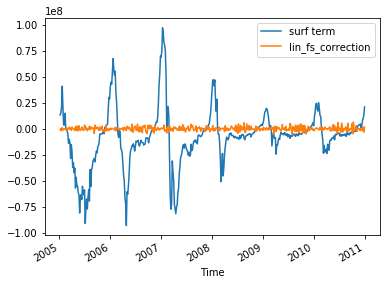

In [22]:
surface_term.plot(label='surf term')
lin_fs_correction.plot(label='lin_fs_correction')
plt.legend();

In [ ]:
#is it hFacC or hFacS
total_volume = (coords.rA * coords.drF * coords.hFacC).sum().load()
total_volume

In [ ]:
dsr.TOTTTEND.sel(YC=upper_lat, method='nearest')

In [24]:
dsr.TOTTTEND

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

In [23]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, YC=slice(lower_lat, upper_lat)).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#same longitudinal window as lin_fs_correction (63.541634)
#units: (˚C m^3)/day

<xarray.DataArray (time: 438)>
array([20528211.437037, 29680137.860741, 36311992.699259, ..., 22309311.525926,
       21789313.706667, 32536263.49037 ])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

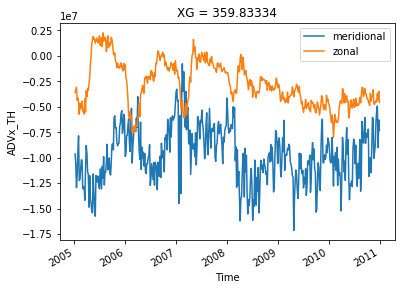

In [25]:
adv_flux_y.plot(label='meridional')
adv_flux_x.plot(label='zonal')
plt.legend();

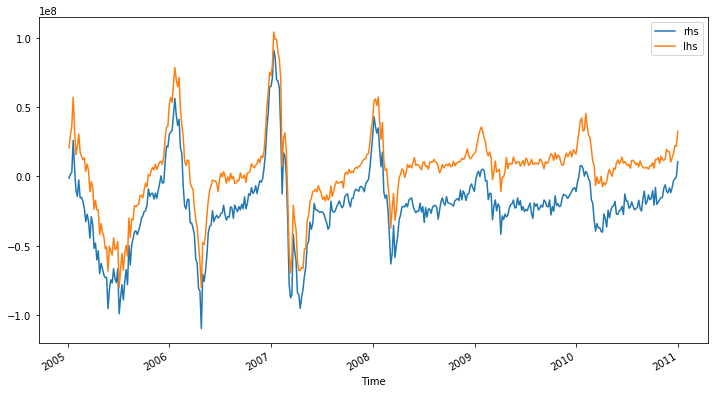

In [39]:
rhs = + adv_flux + diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend();

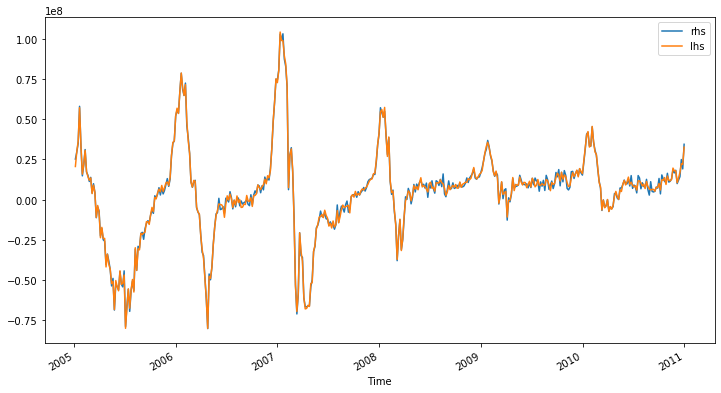

In [38]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend();

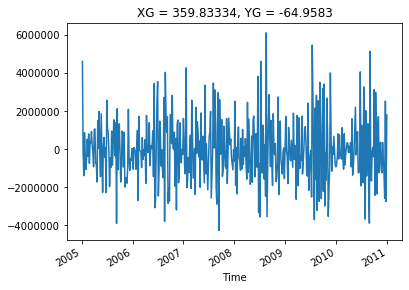

In [30]:
#better than (rhs+lhs) - order of magnitude of 6
(rhs - lhs).plot()

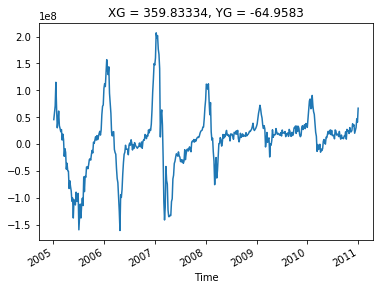

In [31]:
(rhs + lhs).plot() #order of magnitude of 8

In [32]:
(rhs - lhs).mean().load()

<xarray.DataArray ()>
array(-26429.637646)
Coordinates:
    XG       float32 359.83334
    YG       float32 -64.9583

In [33]:
all_terms = xr.merge([tottend_weddell.rename('tottend'),
                      adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG         float32 359.83334
    YG         float32 -64.9583
Data variables:
    tottend    (time) float64 2.053e+07 2.968e+07 ... 2.179e+07 3.254e+07
    adv_flux   (time) float32 -13221805.0 -13907859.0 ... -9747787.0 -11887119.0
    diff_flux  (time) float32 -7607.662 -13723.151 ... 43410.203 30665.426
    lin_fs     (time) float32 -1361935.0 348860.16 ... -3285659.2 1495456.5
    surface    (time) float32 13282954.0 15234938.0 ... 12627299.0 20979914.0

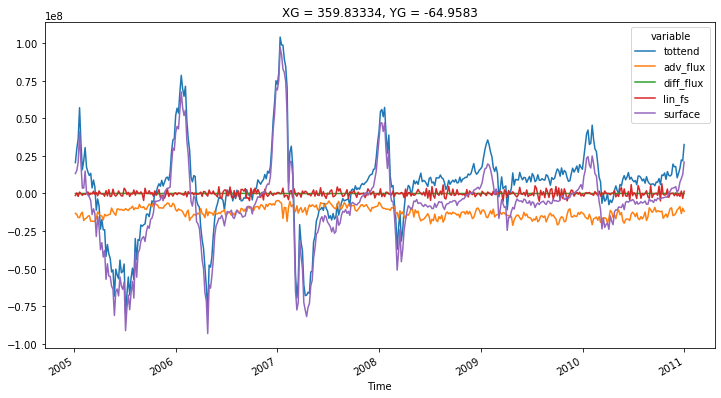

In [37]:
plt.figure(figsize=(12,6))
all_terms.to_array().plot.line(x='time')

In [40]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
tottend,4.247488e+06
adv_flux,-1.249413e+07
diff_flux,8.028716e+03
lin_fs,-3.539490e+04
surface,-8.229648e+06


In [ ]:
rhs_minus_lhs = df.iloc[0] - df.iloc[1:2].sum() + df.iloc[3:4].sum()
rhs_minus_lhs

In [43]:
budget_diff = rhs.sum() + lhs.sum()
budget_diff.load()

<xarray.DataArray ()>
array(-7.228602e+09)
Coordinates:
    XG       float32 359.83334
    YG       float32 -64.9583

In [44]:
budget_diff = lhs.sum() - rhs.sum()
budget_diff.load()

<xarray.DataArray ()>
array(-1.09494e+10)
Coordinates:
    XG       float32 359.83334
    YG       float32 -64.9583

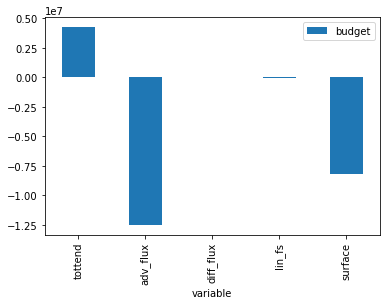

In [42]:
df.plot(kind='bar')

# Heat budget for lower part of WG

## Heat component of buoyancy budget integrated over lower Weddell Sea Region
Here, $\mathcal{V}$, represents the closed system of the Weddell Sea.

$$
\int_{R}{\frac{\partial{\theta}}{\partial{t}}}d\mathcal{V} = -\int_{NB}F^{\theta}_{adv,\mathbf{x}}dA - \int_{NB} F^{\theta}_{diff,\mathbf{x}}dA
$$

where 'NB' denotes northern boundary of region R; and the $F^{\theta}_{diff}$ term includes the explicit, implicit and KPP variables from SOSE dataset.

In [6]:
sst_mean_lower = dsr.THETA.sel(Z=slice(-2e03, -5.575e03)).mean(dim=['time', 'Z']).load()

In [7]:
coords.hFacC.sel(Z=-2e03, method='nearest')

<xarray.DataArray 'hFacC' (YC: 320, XC: 2160)>
dask.array<shape=(320, 2160), dtype=float32, chunksize=(320, 2160)>
Coordinates:
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Z        float32 -2046.0
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction

In [8]:
surface_mask_lower = (coords.hFacC.sel(Z=-2046.0)>0).load()

** DRY = don't repeat yourself **

In [9]:
left_lon_lower = 304.5
upper_lat_lower = -61
right_lon_lower = 360
lower_lat_lower =-80

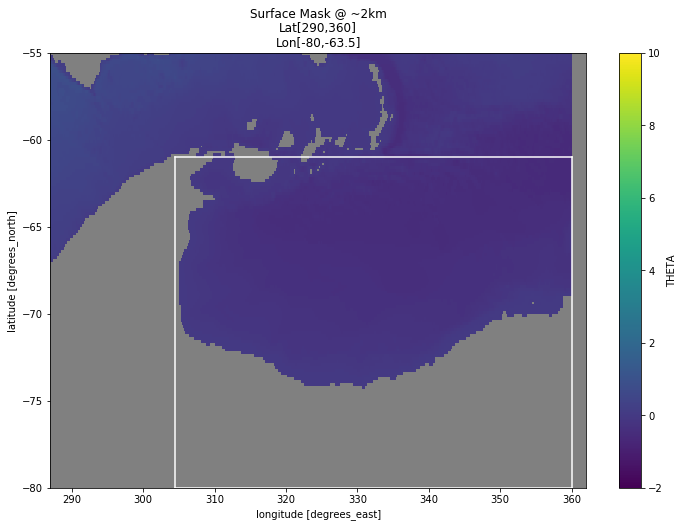

In [11]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean_lower.where(surface_mask_lower)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon_lower, right_lon_lower], [upper_lat_lower, upper_lat_lower], color='w')
ax.plot([right_lon_lower, right_lon_lower], [lower_lat_lower, upper_lat_lower], color='w')
ax.plot([left_lon_lower, left_lon_lower], [lower_lat_lower, upper_lat_lower], color='w')
ax.plot([left_lon_lower, right_lon_lower], [lower_lat_lower, lower_lat_lower], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ ~2km\nLat[290,360]\nLon[-80,-63.5]');

In [12]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))
lower_cell_range = dict(Z=slice(-2e03, -5.575e03))

In [13]:
dsr.ADVy_TH.sel(YG=-63.5, method='nearest')

<xarray.DataArray 'ADVy_TH' (time: 438, Z: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YG       float32 -63.4583
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Meridional Advective Flux of Pot.Temperature
    mate:           ADVx_TH
    standard_name:  ADVy_TH
    units:          degC.m^3/s

In [ ]:
dsr.ADVx_TH.sel(YC=-63.5, method='nearest')

In [ ]:
dsr.ADVr_TH.sel(YC=-63.5, method='nearest')

In [ ]:
dsr.ADVr_TH.sel(Zl=-2.1e03, method='nearest')

In [14]:
#advective flux
adv_flux_y_lower = dsr.ADVy_TH.sel(**lon_range_lower, **lower_cell_range).sel(
                                              YG=-63.4583, method='nearest').sum(dim=['XC', 'Z']).load()
adv_flux_x_lower = dsr.ADVx_TH.sel(**lat_range_lower, **lower_cell_range).sel(
                                              XG=360, method='nearest').sum(dim=['YC', 'Z']).load()
adv_flux_z_lower = dsr.ADVr_TH.sel(**lon_range_lower, **lat_range_lower).sel(
                                              Zl=-2.1e03, method='nearest').sum(dim=['XC', 'YC']).load()
adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-2604162.5 ,  -739763.4 ,  1509120.2 , ...,  2810936.8 ,  1678199.9 ,
         843755.44], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -63.4583
    Zl       float32 -2188.0

In [ ]:
dsr.DFrE_TH.sel(Zl=-2.1e03, method='nearest')

In [ ]:
dsr.DFrI_TH.sel(Zl=-2.1e03, method='nearest')

In [ ]:
dsr.KPPg_TH.sel(Zl=-2.1e03, method='nearest')

In [15]:
#diffusive flux
diff_flux_y_lower = dsr.DFyE_TH.sel(**lon_range_lower, **lower_cell_range).sel(YG=-63.4583, 
                                                         method='nearest').sum(dim=['XC', 'Z']).load()
diff_flux_x_lower = dsr.DFxE_TH.sel(**lat_range_lower, **lower_cell_range).sel(XG=360, 
                                                         method='nearest').sum(dim=['YC', 'Z']).load()
diff_flux_z_lower = (dsr.DFrE_TH.sel(**lon_range_lower, **lat_range_lower).sel(Zl=-2.1e03, 
                                                         method='nearest').sum(dim=['XC', 'YC'])
                   + dsr.DFrI_TH.sel(**lon_range_lower, **lat_range_lower).sel(Zl=-2.1e03, 
                                                         method='nearest').sum(dim=['XC', 'YC'])
                   + dsr.KPPg_TH.sel(**lon_range_lower, **lat_range_lower).sel(Zl=-2.1e03, 
                                                         method='nearest').sum(dim=['XC', 'YC'])).load()

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-2.136365e+07,  1.594750e+03,  2.557583e+02, ..., -2.283568e+04,
       -2.182380e+04, -1.820542e+04], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -63.4583
    Zl       float32 -2188.0

In [17]:
tottend_weddell_lower = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC).sel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range).sum(
                         dim=['XC', 'YC', 'Z']) / (24*60*60)

tottend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([25671416.035556,  2000078.127407,   389272.651852, ...,  1158466.465185,
         848658.678519,  1837109.854815])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

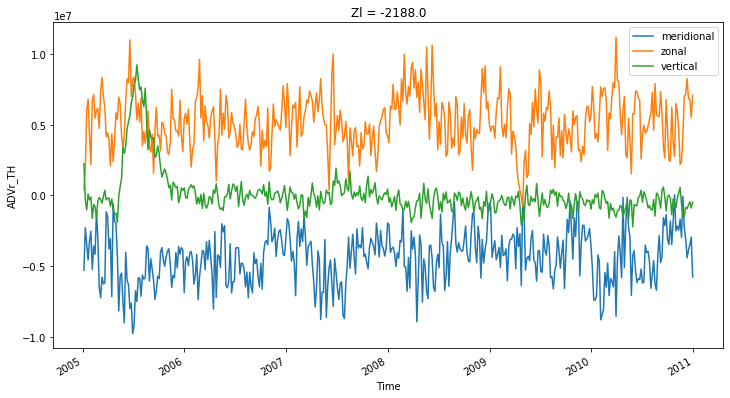

In [18]:
plt.figure(figsize=(12,6))
adv_flux_y_lower.plot(label='meridional')
adv_flux_x_lower.plot(label='zonal')
adv_flux_z_lower.plot(label='vertical')
plt.legend();
#vertical is positive, i think that means upwelling (which there is considerable upwelling in the 
#WG region - fun exercise would be to figure out what region specifically is producing this upwelling)
#meridional is negative which probably means it's moving poleward 
#zonal is positive - why?

# spike doesn't rep real polynya in real ocean (only real in SOSE)

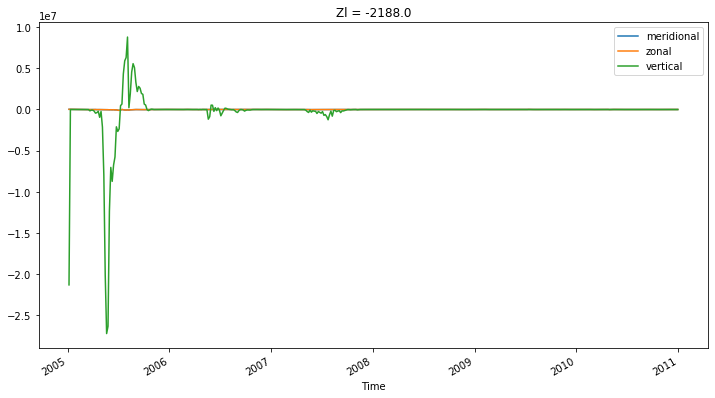

In [19]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='meridional')
diff_flux_x_lower.plot(label='zonal')
diff_flux_z_lower.plot(label='vertical')
plt.legend();

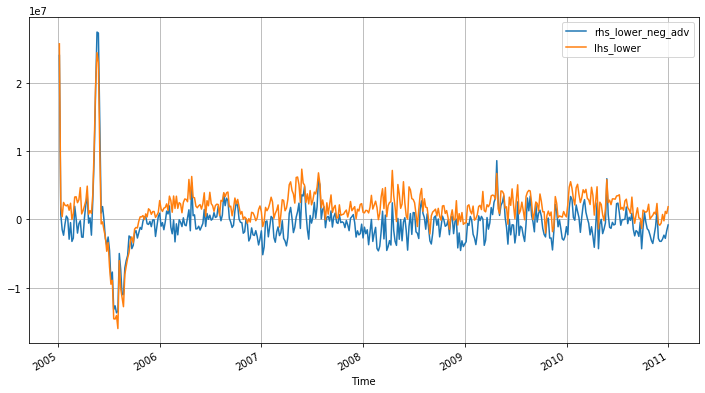

In [29]:
plt.figure(figsize=(12,6))
rhs_lower_neg_adv = - (adv_flux_lower + diff_flux_lower) 
lhs_lower = tottend_weddell_lower
rhs_lower_neg_adv.plot(label='rhs_lower_neg_adv')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();

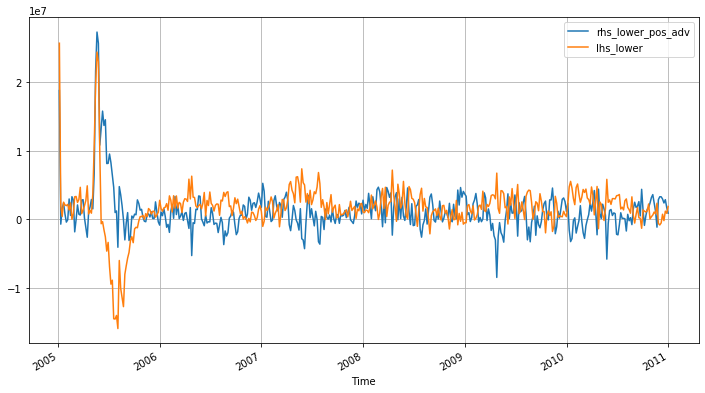

In [28]:
plt.figure(figsize=(12,6))
rhs_lower_pos_adv = adv_flux_lower - diff_flux_lower
lhs_lower = tottend_weddell_lower
rhs_lower_pos_adv.plot(label='rhs_lower_pos_adv')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();

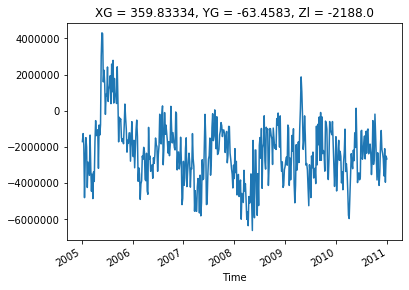

In [30]:
(rhs_lower_neg_adv - lhs_lower).plot() #neg is better

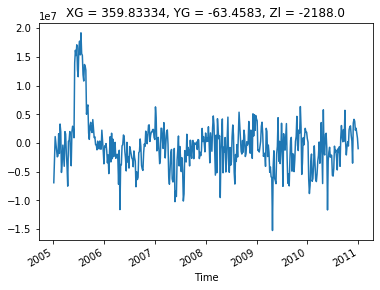

In [31]:
(rhs_lower_pos_adv - lhs_lower).plot()

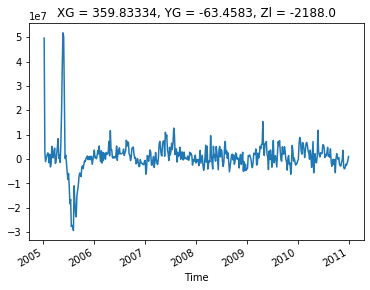

In [32]:
(rhs_lower_neg_adv + lhs_lower).plot()

In [33]:
(rhs_lower_neg_adv - lhs_lower).mean().load()

<xarray.DataArray ()>
array(-2293156.718898)
Coordinates:
    XG       float32 359.83334
    YG       float32 -63.4583
    Zl       float32 -2188.0

In [72]:
all_terms_lower = xr.merge([tottend_weddell_lower.rename('tottend'),
                      adv_flux_lower.rename('adv_flux'),
                      diff_flux_lower.rename('diff_flux')])
all_terms_lower

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG         float32 359.83334
    YG         float32 -63.4583
    Zl         float32 -2188.0
Data variables:
    tottend    (time) float64 2.567e+07 2e+06 3.893e+05 ... 8.487e+05 1.837e+06
    adv_flux   (time) float32 -2604162.5 -739763.4 ... 1678199.9 843755.44
    diff_flux  (time) float32 -21363646.0 1594.7495 ... -21823.803 -18205.422

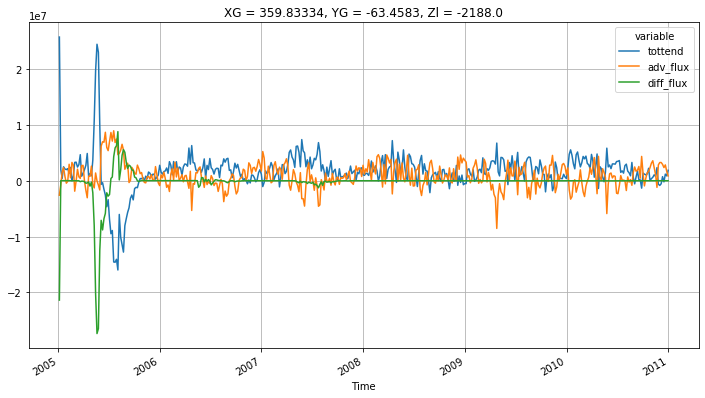

In [35]:
plt.figure(figsize=(12,6))
all_terms_lower.to_array().plot.line(x='time')
plt.grid();

In [73]:
df_lower = all_terms_lower.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(
                                                                                        name='budget')
df_lower

,budget
variable,
tottend,1.635784e+06
adv_flux,9.334452e+05
diff_flux,-2.760723e+05


In [ ]:
rhs_minus_lhs_lower = df_lower.iloc[0] + df_lower.iloc[1:].sum()
rhs_minus_lhs_lower

In [ ]:
budget_diff_lower = rhs_lower.sum() + lhs_lower.sum()
budget_diff_lower.load()

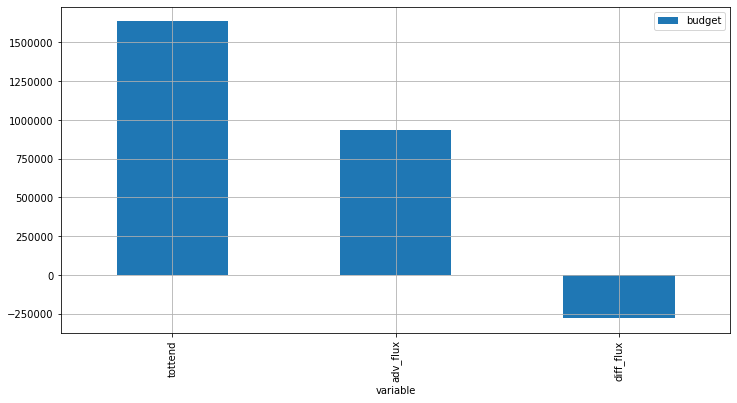

In [74]:
df_lower.plot(figsize=(12,6), kind='bar')
plt.grid();
#if adv were negative the budget would be better...

In [ ]:
tottend_weddell_lower.plot(label='dT/dt')
adv_flux_lower.plot(label='advective term')
diff_flux_lower.plot(label='diffusive term')
plt.legend();
#expected to see diffusive term being more prominant in the lower WG region